In [285]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as c

In [286]:
#Define relevant parameters
R = (0.001 * u.pc).to(u.cm) #Define the radius of cloud
M = (1 * c.M_sun).to(u.g) #Define the mass of cloud
rho = M / ((4 / 3) * np.pi * R**3) #Calculate density of cloud
n = rho / c.m_p.to(u.g) #Calculate number density of cloud assuming all ionized H
sigma = c.sigma_T.to(u.cm*u.cm) #Define Thomson cross section
l = 1/ (n*sigma) #Calculate mean free path
n_shells = 100 
dr = R / n_shells #Divide radius of cloud into 100 thin shells of radius dr

In [287]:
def RandomWalk():
    x = [0] #Start at origin
    y = [0]
    z = [0]
    r = 0 * u.pc
    step = 0 #Count number of steps taken
    radii = []

    while r < R.to(u.pc): #Random walk while inside cloud
        step += 1
        #Randomly sample across the sphere (following method by Cory Simon)
        phi = 2*np.pi*np.random.uniform(0.0,1.0) #
        theta = np.arccos(1-2*np.random.uniform(0.0,1.0))

        #Convert to Cartesian coordinates
        x.append(x[step-1]+l.to(u.pc).to_value()*np.sin(theta)*np.cos(phi))
        y.append(y[step-1]+l.to(u.pc).to_value()*np.sin(theta)*np.sin(phi))
        z.append(z[step-1]+l.to(u.pc).to_value()*np.cos(theta))

        r = np.sqrt(x[step]**2 + y[step]**2 + z[step]**2) * u.pc #Calculate distance from origin at each point
        radii.append(r)
        
    return x,y,z,radii,step
    

Text(0.5, 0.92, 'Single Random Walk')

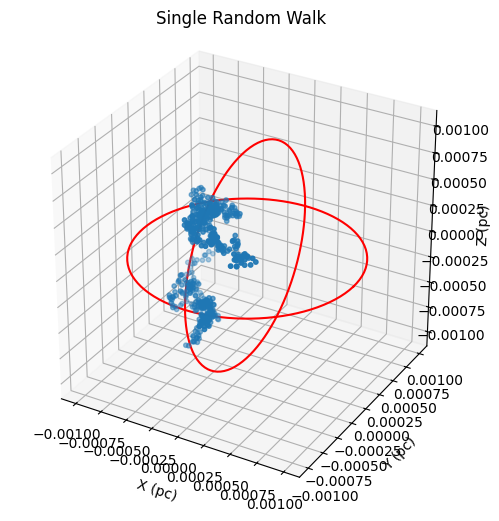

In [303]:
#Calculate and plot a single random walk
x,y,z,radii,step = RandomWalk()
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, s=10)

#Plot circles showing boundary of cloud
theta = np.linspace(0, 2 * np.pi, 100)
x_circ1 = R.to(u.pc).to_value() * np.cos(theta)
y_circ1 = R.to(u.pc).to_value() * np.sin(theta)
z_circ1 = np.zeros_like(x_circ1)

y_circ2 = R.to(u.pc).to_value() * np.cos(theta)
z_circ2 = R.to(u.pc).to_value() * np.sin(theta)
x_circ2 = np.zeros_like(y_circ2)

ax.plot(x_circ1,y_circ1,z_circ1, color = 'red')
ax.plot(x_circ2,y_circ2,z_circ2, color = 'red')

ax.set_aspect('equal')
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')
ax.set_title('Single Random Walk')

The above is for one random walk. Now let's simulate this 1000s of times in order to get some aggregate statistics

In [293]:
#Define all our functions

def Simulations(N):
    step_aggregate = []
    radii_aggregate = []
    for i in range(N): #Produce N random walks
        x,y,z,radii,step = RandomWalk()
        step_aggregate.append(step)
        radii_aggregate.append(radii)
    return np.array(step_aggregate),radii_aggregate #Return the number of steps of each random walk as well as the array of radii of each random walk

def distance(steps_array):
    return l.to(u.pc) * steps_array #Calculate the total distance traveled in each random walk (in parsecs)

def LastScattering(radii_array):
    last_scattering = []
    for sim in radii_array:
        last_scattering.append(sim[-2]) #Collect the last radii each random walk landed at before exiting cloud
    return last_scattering

def densities(radii_array):
    bins = np.arange(0,R.to(u.pc).to_value(),dr.to(u.pc).to_value()) #Define bins that we'll split radii into to determine density

    densities_aggregate = []
    for sim in radii_array:
        densities = []
        counts, edges = [],[]
        sim_val = [s.to_value() for s in sim] 
        counts, edges = np.histogram(sim_val, bins=bins) #Divide radii into bins of equal size dr
        for i in range(len(counts)):
            rad = 0.5 * (edges[i] + edges[i+1]) 
            V = 4 * np.pi * rad**2 * dr.to(u.pc).to_value() #Calculate the volume of each shell
            density = counts[i] / V #Compute the density of at each shell
            densities.append(density)
        densities_aggregate.append(densities)

    densities_aggregate_np = np.array([np.array([density for density in sim]) for sim in densities_aggregate]) #Convert to numpy array

    averaged_densities = np.zeros(len(densities_aggregate_np[0]))
    
    temp_array = np.zeros(len(densities_aggregate_np[0]))

    for array in densities_aggregate_np:
        temp_array += array
    averaged_densities = temp_array / len(densities_aggregate_np) #Compute the average density for each shell across all simulations

    return averaged_densities

In [294]:
#Conduct simulations and collect relevant parameters
step_aggregate, radii_aggregate = Simulations(5000) #Run 5000 simulations

distances = distance(step_aggregate) #Calculate total distance traveled for each random walk

last_scattering = LastScattering(radii_aggregate) #Calculate radii of last scattering for each random walk

averaged_densities = densities(radii_aggregate) #Calculate intensity density as a function of radius

Text(0.5, 1.0, 'Distribution of Total Path Distances Across All Simulations')

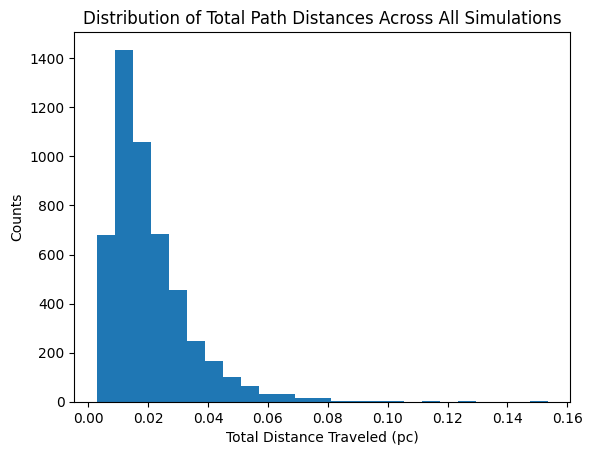

In [295]:
plt.hist(distances, bins=25)
plt.xlabel('Total Distance Traveled (pc)')
plt.ylabel('Counts')
plt.title('Distribution of Total Path Distances Across All Simulations')

Text(0.5, 1.0, 'Distribution of Surfaces of Last Scattering Across All Simulations')

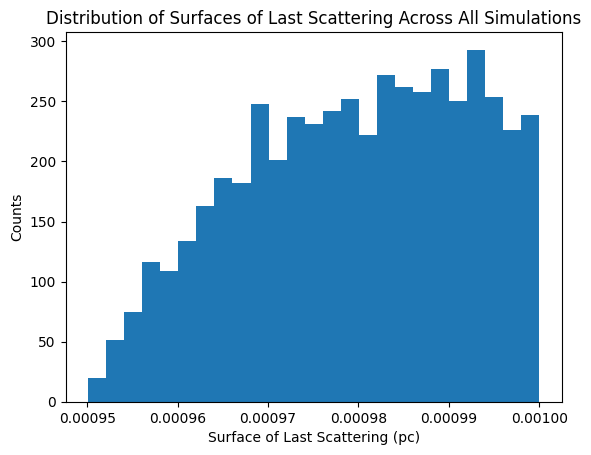

In [311]:
plt.hist(last_scattering, bins=25)
plt.xlabel('Surface of Last Scattering (pc)')
plt.ylabel('Counts')
plt.title('Distribution of Surfaces of Last Scattering Across All Simulations')

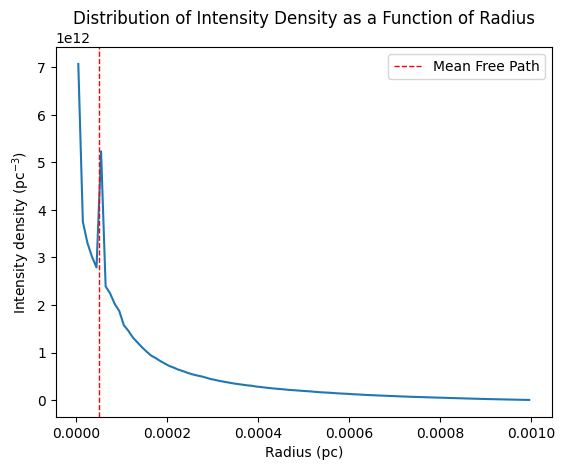

In [306]:
bins = np.arange(0,R.to(u.pc).to_value(),dr.to(u.pc).to_value())
midpoints = []
for i in range(len(bins)-1):
    midpoints.append(.5 * (bins[i]+bins[i+1])) #Calculate the midpoints of each bin to use for plotting purposes
plt.plot(midpoints, averaged_densities)
plt.xlabel('Radius (pc)')
plt.ylabel('Intensity density (pc$^{-3}$)')
plt.title('Distribution of Intensity Density as a Function of Radius')
plt.axvline(x=l.to(u.pc).to_value(), color='r', linestyle='--', linewidth=1, label = 'Mean Free Path') #Plot mean free path
plt.legend()

## Extra Credit

In [324]:
#Define relevant parameters
R = (0.001 * u.pc).to(u.cm) #Define the radius of cloud
M = (1 * c.M_sun).to(u.g) #Define the mass of cloud
m = c.m_p.to(u.g)

sigma = c.sigma_T.to(u.cm*u.cm) #Define Thomson cross section

n_shells = 100 
dr = R / n_shells #Divide radius of cloud into 100 thin shells of radius dr

In [329]:
#Function to calculate mean free path at a given radius
def mfp(r):
    n = ((M * np.e) / (4 * np.pi * m * (2*np.e - 5)* R**3) ) * np.exp(-r/R)
    l = 1 / (n*sigma)
    return l

In [344]:
#Define a random walk function that takes into account changing mean free path
def RandomWalkExtra():
    x = [0] #Start at origin
    y = [0]
    z = [0]
    r = 0 * u.pc
    step = 0
    distance = 0
    radii = []

    while r < R.to(u.pc): #Random walk while inside cloud
        step += 1
        #Randomly sample across the sphere (following method by Cory Simon)
        phi = 2*np.pi*np.random.uniform(0.0,1.0) #
        theta = np.arccos(1-2*np.random.uniform(0.0,1.0))

        l = mfp(r) #Update mean free path
        distance += l 

        #Convert to Cartesian coordinates
        x.append(x[step-1]+l.to(u.pc).to_value()*np.sin(theta)*np.cos(phi))
        y.append(y[step-1]+l.to(u.pc).to_value()*np.sin(theta)*np.sin(phi))
        z.append(z[step-1]+l.to(u.pc).to_value()*np.cos(theta))

        r = np.sqrt(x[step]**2 + y[step]**2 + z[step]**2) * u.pc #Calculate distance from origin at each point
        radii.append(r)
        
    return x,y,z,radii,distance

#Define a new function that uses the above random walk function
def SimulationsExtra(N):
    distances = []
    radii_aggregate = []
    for i in range(N): #Produce N random walks
        x,y,z,radii,distance = RandomWalkExtra()
        distances.append(distance)
        radii_aggregate.append(radii)
    return distances,radii_aggregate #Return the number of steps of each random walk as well as the array of radii of each random walk

In [345]:
#Conduct simulations and collect relevant parameters
distancesExtra, radii_aggregateExtra = SimulationsExtra(1000) #Run 1000 simulations

last_scatteringExtra = LastScattering(radii_aggregateExtra) #Calculate radii of last scattering for each random walk

averaged_densitiesExtra = densities(radii_aggregateExtra) #Calculate intensity density as a function of radius

Text(0.5, 1.0, 'Distribution of Total Path Distances Across All Simulations')

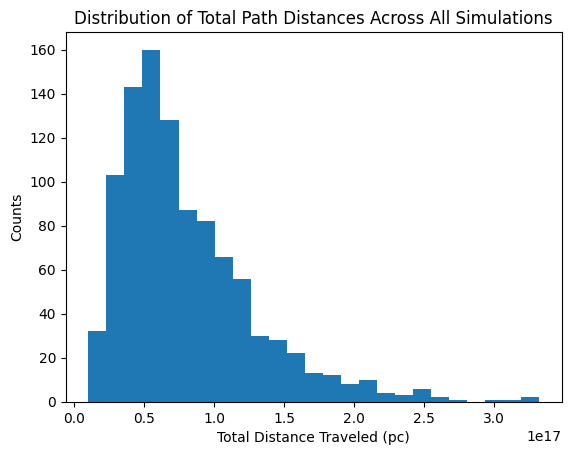

In [346]:
plt.hist(distancesExtra, bins=25)
plt.xlabel('Total Distance Traveled (pc)')
plt.ylabel('Counts')
plt.title('Distribution of Total Path Distances Across All Simulations')

Text(0.5, 1.0, 'Distribution of Surfaces of Last Scattering Across All Simulations')

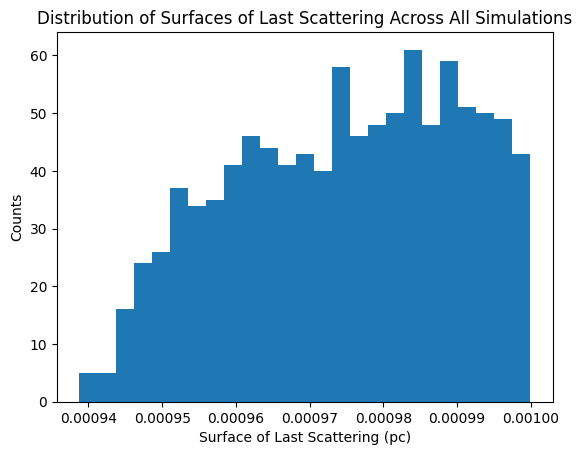

In [347]:
plt.hist(last_scatteringExtra, bins=25)
plt.xlabel('Surface of Last Scattering (pc)')
plt.ylabel('Counts')
plt.title('Distribution of Surfaces of Last Scattering Across All Simulations')

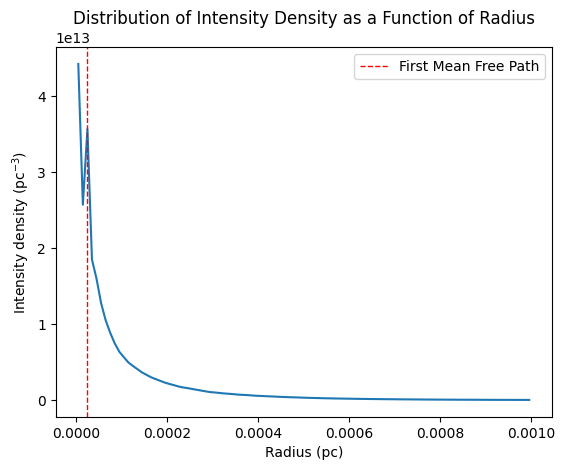

In [351]:
bins = np.arange(0,R.to(u.pc).to_value(),dr.to(u.pc).to_value())
midpoints = []
for i in range(len(bins)-1):
    midpoints.append(.5 * (bins[i]+bins[i+1])) #Calculate the midpoints of each bin to use for plotting purposes
plt.plot(midpoints, averaged_densitiesExtra)
plt.xlabel('Radius (pc)')
plt.ylabel('Intensity density (pc$^{-3}$)')
plt.title('Distribution of Intensity Density as a Function of Radius')
l = mfp(radii_aggregateExtra[0][0])
plt.axvline(x=l.to(u.pc).to_value(), color='r', linestyle='--', linewidth=1, label = 'First Mean Free Path') #Plot mean free path
plt.legend()